In [19]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.metrics import make_scorer, recall_score, f1_score,precision_score

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

import xgboost as xgb
from xgboost import XGBClassifier

from imblearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline as imPipeline
from imblearn.over_sampling import SMOTE

from joblib import dump, load
import mlflow
import dagshub
import pickle
import shap

from my_utilities import custom_loss, custom_scorer

import evidently
from evidently.metrics import ColumnDriftMetric
from evidently.metrics import ColumnSummaryMetric
from evidently.metrics import DatasetDriftMetric
from evidently.metrics import DatasetMissingValuesMetric
from evidently.report import Report
from evidently.test_preset import DataDriftTestPreset
from evidently.test_suite import TestSuite
from evidently.ui.dashboards import CounterAgg
from evidently.ui.dashboards import DashboardPanelCounter
from evidently.ui.dashboards import DashboardPanelPlot
from evidently.ui.dashboards import PanelValue
from evidently.ui.dashboards import PlotType
from evidently.ui.dashboards import ReportFilter
from evidently.ui.remote import RemoteWorkspace
from evidently.ui.workspace import Workspace
from evidently.ui.workspace import WorkspaceBase

In [20]:
import evidently
print(evidently.__version__)

0.4.1


In [21]:
dagshub.init("Projet7", "alexandre", mlflow=True)

Repository initialized!

In [22]:
mlflow.set_tracking_uri("https://dagshub.com/alexandre/Projet7.mlflow")

In [23]:
mlflow.set_experiment("XGBoost")

<Experiment: artifact_location='mlflow-artifacts:/04e0537cf3f7468b8c6418159d45db8e', creation_time=1692228764226, experiment_id='0', last_update_time=1692228764226, lifecycle_stage='active', name='XGBoost', tags={}>

In [24]:
# chargement de base de données
df = pd.read_csv("../Data/Processed/fichier_xgb.csv", index_col="SK_ID_CURR")

In [25]:
# Définir la fonction de perte personnalisée
def custom_loss(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    fn_weight = 10.0  # poids pour les faux négatifs
    fp_weight = 10.0  # poids pour les faux positifs
    return cm[0, 1] * fp_weight + cm[1, 0] * fn_weight

In [26]:
# Faire une fonction d'évaluation personnalisée pour GridSearch
custom_scorer = make_scorer(custom_loss, greater_is_better=False)

In [27]:
# Séparer les données d'entraînement et de test
train_test_data = df.dropna(subset=["TARGET"])
X = train_test_data.drop(columns=["TARGET"])
y = train_test_data["TARGET"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [28]:
# Initialiser le DummyClassifier
dummy_clf = DummyClassifier(
    strategy="most_frequent"
)  # ou une autre stratégie de votre choix

# Former le modèle avec les données d'entraînement
dummy_clf.fit(X_train, y_train)

# Prédire avec le DummyClassifier
y_pred_dummy = dummy_clf.predict(X_test)

# Calculer les métriques pour le DummyClassifier
roc_auc_dummy = roc_auc_score(y_test, y_pred_dummy)
accuracy_dummy = accuracy_score(y_test, y_pred_dummy)
cm_dummy = confusion_matrix(y_test, y_pred_dummy)

# Enregistrement de la matrice de confusion pour le DummyClassifier
path_cm_dummy = "../src/models/confusion_matrix_dummy.txt"
with open(path_cm_dummy, "w") as f:
    f.write(str(cm_dummy))

# Début de l'exécution MLflow pour le modèle Dummy
with mlflow.start_run(run_name="Dummy") as run:
    # Enregistrer les métriques pour le DummyClassifier
    mlflow.log_metric("roc_auc_dummy", roc_auc_dummy)
    mlflow.log_metric("accuracy", accuracy_dummy)

    # Enregistrer la matrice de confusion en tant qu'artefact
    mlflow.log_artifact(path_cm_dummy)

    # Enregistrer le modèle DummyClassifier
    mlflow.sklearn.log_model(dummy_clf, "dummy_model")

2023/08/19 19:17:25 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\arken\AppData\Local\Temp\tmpp3s0tacf\model\model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.2.1', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback.
Setuptools is replacing distutils.


In [29]:
print("ROC AUC =", roc_auc_dummy)
print("ACCURACY =", accuracy_dummy)
print(cm_dummy)

ROC AUC = 0.5
ACCURACY = 0.9188213484242365
[[56502     0]
 [ 4992     0]]


In [30]:
# Instancier le modèle XGBoost
model_xgb_opti = xgb.XGBClassifier()

# Création du pipeline
pipeline = imPipeline([("smote", SMOTE()), ("xgb", model_xgb_opti)])

# Paramètres à tester
param_grid = {
    "xgb__max_depth": [7],
    "xgb__learning_rate": [0.1],
    "xgb__n_estimators": [200],
}

# Création du GridSearch
grid_search_xgb_opti = GridSearchCV(
    estimator=pipeline, param_grid=param_grid, scoring=custom_scorer, cv=3, n_jobs=-1
)

# Adapter le modèle
grid_search_xgb_opti.fit(X_train, y_train)

# Prédire sur l'ensemble de test
y_pred = grid_search_xgb_opti.predict(X_test)

In [31]:
path_cm_xgb = "../src/models/confusion_matrix_xgb.txt"
cmxgb = confusion_matrix(y_test, y_pred)

# Enregistrer la matrice de confusion sous forme de texte
with open(path_cm_xgb, "w") as f:
    f.write(str(cmxgb))

with mlflow.start_run(run_name="XGB") as run:

    roc_auc = roc_auc_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    score_matrix = custom_loss(y_test, y_pred)

    # Enregistrement des métriques dans MLflow
    mlflow.log_metric("ROC AUC Score", roc_auc)
    mlflow.log_metric("ACCURACY", accuracy)
    mlflow.log_metric("SCORE MATRIX", score_matrix)

    # Enregistrer la matrice de confusion sous forme de texte
    mlflow.log_artifact(path_cm_xgb)

    # Enregistrer les paramètres
    mlflow.log_params({"max_depth": 7, "learning_rate": 0.1, "n_estimators": 200})

    # Enregistrer le modèle
    mlflow.sklearn.log_model(grid_search_xgb_opti.best_estimator_, "best_model")

In [32]:
print(f"ROC AUC Score: {roc_auc*100:.2f}%")
print(f"ACCURACY: {accuracy*100:.2f}%")
print(f"Confusion Matrix: {cmxgb}")
print(f"SCORE MATRICE: {score_matrix}")

ROC AUC Score: 61.72%
ACCURACY: 81.63%
Confusion Matrix: [[48300  8202]
 [ 3097  1895]]
SCORE MATRICE: 112990.0


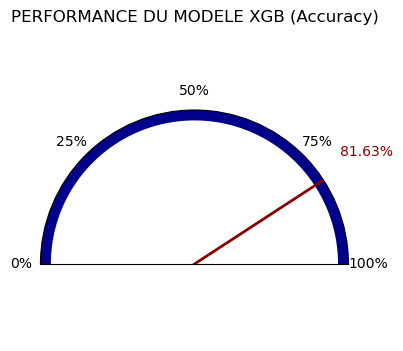

In [33]:
def draw_gauge(accuracy_score):
    # Normaliser le score entre 0 et 1
    normalized_score = accuracy_score

    # Créer un axe polar
    fig, ax = plt.subplots(figsize=(4, 4), subplot_kw={"polar": True})

    # Dessiner l'arc de la jauge (demi-cercle supérieur)
    arc = np.linspace(0, np.pi, 100)
    r = np.full(100, 0.6)
    ax.plot(arc, r, color="darkblue", linewidth=15)

    # Calculer l'angle pour l'aiguille
    theta = np.pi * (normalized_score)
    ax.plot([theta, theta], [0, 0.6], color='darkred', linewidth=2)

    # Marquer le score sur l'aiguille
    ax.text(theta , 0.8, f"{accuracy_score * 100:.2f}%", color='darkred', ha="center", va="center")

    # Configurer les angles et étiquettes en pourcentage
    ax.set_theta_zero_location("W")
    ax.set_theta_direction(-1)
    ax.set_xticks(np.radians([0, 45, 90, 135, 180]))
    ax.set_xticklabels(["0%", "25%", "50%", "75%", "100%"])

    # Supprimer les rayons et les étiquettes radiales
    ax.set_yticks([])
    ax.set_yticklabels([])

    # Supprimer les lignes radiales
    ax.grid(False)

    # Réduire la vue au demi-cercle
    ax.set_ylim([0, 0.6])
    ax.set_xlim([0, np.pi])

    ax.set_title("PERFORMANCE DU MODELE XGB (Accuracy)", va="bottom")

    plt.show()

    fig.savefig("../src/utils/images/jauge_xgb.png")

accuracy_value = accuracy
draw_gauge(accuracy_value)

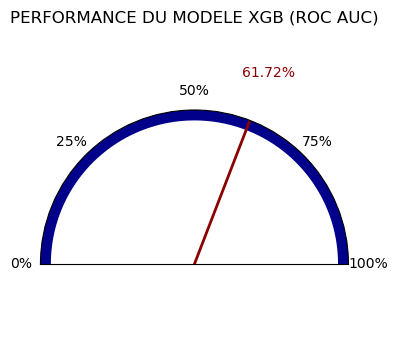

In [34]:
def draw_gauge(accuracy_score):
    if not np.isscalar(accuracy_score):
        raise ValueError("La valeur fournie à 'draw_gauge' doit être un scalaire.")

    # Normaliser le score entre 0 et 1
    normalized_score = accuracy_score

    # Créer un axe polar
    fig, ax = plt.subplots(figsize=(4, 4), subplot_kw={"polar": True})

    # Dessiner l'arc de la jauge (demi-cercle supérieur)
    arc = np.linspace(0, np.pi, 100)
    r = np.full(100, 0.6)
    ax.plot(arc, r, color="darkblue", linewidth=15)

    # Calculer l'angle pour l'aiguille
    theta = np.pi * (normalized_score)
    ax.plot([theta, theta], [0, 0.6], color='darkred', linewidth=2)

    # Marquer le score sur l'aiguille
    ax.text(theta , 0.8, f"{accuracy_score * 100:.2f}%", color='darkred', ha="center", va="center")

    # Configurer les angles et étiquettes en pourcentage
    ax.set_theta_zero_location("W")
    ax.set_theta_direction(-1)
    ax.set_xticks(np.radians([0, 45, 90, 135, 180]))
    ax.set_xticklabels(["0%", "25%", "50%", "75%", "100%"])

    # Supprimer les rayons et les étiquettes radiales
    ax.set_yticks([])
    ax.set_yticklabels([])

    # Supprimer les lignes radiales
    ax.grid(False)

    # Réduire la vue au demi-cercle
    ax.set_ylim([0, 0.6])
    ax.set_xlim([0, np.pi])

    ax.set_title("PERFORMANCE DU MODELE XGB (ROC AUC)", va="bottom")

    plt.show()

    fig.savefig("../src/utils/images/jauge_xgb_auc.png")

accuracy_value = roc_auc
draw_gauge(accuracy_value)

In [35]:
y_pred_proba = grid_search_xgb_opti.predict_proba(X_test)[:, 1]

# Calculer la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

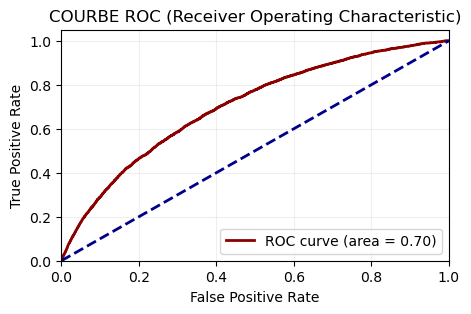

In [36]:
# Créer la figure et l'axe
fig, ax = plt.subplots(figsize=(5, 3))

# Tracer la courbe ROC sur l'axe
ax.plot(fpr, tpr, color='darkred', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
ax.plot([0, 1], [0, 1], color='darkblue', lw=2, linestyle='--')  # ligne diagonale pour un modèle aléatoire
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('COURBE ROC (Receiver Operating Characteristic)')
ax.legend(loc="lower right")
ax.grid(alpha=0.2)
plt.show()

# Sauvegarder la figure
fig.savefig("../src/utils/images/courbe_roc.png")


In [37]:
mlflow.end_run()

In [38]:
# Enregistrer le modèle et les variables associées avec pickle
file_path = "../projet7_git/xgb_model.pkl"
with open(file_path, "wb") as f:
    pickle.dump(
        {"model": grid_search_xgb_opti, "roc_auc": roc_auc, "confusion_matrix": cmxgb},
        f,
    )

print("Modèle XGBoost et variables enregistrés avec succès.")

Modèle XGBoost et variables enregistrés avec succès.


In [39]:
# Enregistrer le modèle et les variables associées avec pickle
file_path = "../projet7_git/xgb_model.pkl"
with open(file_path, "wb") as f:
    pickle.dump(
        {"model": grid_search_xgb_opti, "roc_auc": roc_auc, "confusion_matrix": cmxgb},
        f,
    )

print("Modèle XGBoost et variables enregistrés avec succès.")

Modèle XGBoost et variables enregistrés avec succès.


In [40]:
from joblib import dump

# Enregistrer le modèle et les variables associées avec joblib
file_path = "../projet7_git/xgb_model.joblib"
data_to_save = {
    "model": grid_search_xgb_opti,
    "roc_auc": roc_auc,
    "confusion_matrix": cmxgb
}

# Utiliser dump pour enregistrer les données
dump(data_to_save, file_path)

print("Modèle XGBoost et variables enregistrés avec succès.")

Modèle XGBoost et variables enregistrés avec succès.


In [41]:
sample_data = {
    "EXT_SOURCE_3": 0.15,  # Je mets un nombre aléatoire entre 0 et 1, car cela semble être une sorte de score.
    "EXT_SOURCE_2": 0.27,
    "NAME_INCOME_TYPE_Working": 1,  # Valeur booléenne ou catégorielle, je garde 1
    "NAME_EDUCATION_TYPE_Secondary / secondary special": 1, 
    "NAME_EDUCATION_TYPE_Higher education": 0,
    "OCCUPATION_TYPE_Core staff": 0,
    "FLAG_DOCUMENT_3": 1,  # Une autre valeur booléenne ou catégorielle
    "AMT_REQ_CREDIT_BUREAU_HOUR": 0.0, 
    "CODE_GENDER": 0,  # Supposons que 0 représente un sexe et 1 l'autre
    "PAYMENT_RATE": 0.065,  # Je mets un nombre aléatoire qui semble être un taux.
    "TARGET": 1.0  # Votre variable cible
}

In [42]:
sample_df = pd.DataFrame([sample_data])
prediction = grid_search_xgb_opti.predict(sample_df.drop(columns="TARGET"))
print(prediction)

[1]


In [43]:
sample_df = pd.DataFrame([sample_data])
probabilities = grid_search_xgb_opti.predict_proba(sample_df.drop(columns="TARGET"))
probability_of_class_1 = probabilities[0][1]
print(f"Probabilité de la classe 1: {probability_of_class_1*100:.2f}%")

Probabilité de la classe 1: 89.51%


In [44]:
# Étape 1: Obtenez les probabilités prédites
y_probs = grid_search_xgb_opti.predict_proba(X_test)[:, 1]

# Étape 2 et 3: Appliquez différents seuils et évaluez chaque seuil
thresholds = np.linspace(0, 1, 50)  # test 50 seuils entre 0 et 1
results = []

for threshold in thresholds:
    y_pred = [1 if prob >= threshold else 0 for prob in y_probs]
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    results.append({
        'Threshold': threshold,
        'Accuracy': accuracy,
        'Recall': recall,
        'Precision': precision,
        'F1 Score': f1,
        'True Positives': tp,
        'False Positives': fp,
        'True Negatives': tn,
        'False Negatives': fn
    })

# Transformez les résultats en un DataFrame pour une analyse facile
results_df = pd.DataFrame(results)

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


In [45]:
results_df

,Threshold,Accuracy,Recall,Precision,F1 Score,True Positives,False Positives,True Negatives,False Negatives
0,0.000000,0.081179,1.000000,0.081179,0.150167,4992,56502,0,0
1,0.020408,0.095213,0.997196,0.082141,0.151780,4978,55625,877,14
2,0.040816,0.127671,0.989583,0.084400,0.155534,4940,53591,2911,52
3,0.061224,0.173578,0.975561,0.087640,0.160832,4870,50698,5804,122
4,0.081633,0.223924,0.958934,0.091519,0.167091,4787,47519,8983,205
5,0.102041,0.278092,0.938101,0.096028,0.174222,4683,44084,12418,309
6,0.122449,0.330488,0.908454,0.100223,0.180530,4535,40714,15788,457
7,0.142857,0.378378,0.883013,0.104828,0.187407,4408,37642,18860,584
8,0.163265,0.423505,0.852564,0.109209,0.193617,4256,34715,21787,736
9,0.183673,0.464826,0.825120,0.113923,0.200204,4119,32037,24465,873


In [46]:
results_df.loc[35]

Threshold              0.714286
Accuracy               0.897649
Recall                 0.124800
Precision              0.244505
F1 Score               0.165252
True Positives       623.000000
False Positives     1925.000000
True Negatives     54577.000000
False Negatives     4369.000000
Name: 35, dtype: float64

Le seuil sera donc à 70%.

In [47]:
# Obtenez les probabilités de la classe positive
probabilities = grid_search_xgb_opti.predict_proba(sample_df.drop(columns="TARGET"))[:, 1]

In [53]:
def draw_client(accuracy_score):
    if not np.isscalar(accuracy_score):
        raise ValueError("La valeur fournie à 'draw_gauge' doit être un scalaire.")

    # Normaliser le score entre 0 et 1
    normalized_score = accuracy_score

    # Créer un axe polar
    fig, ax = plt.subplots(figsize=(4, 4), subplot_kw={"polar": True})

    # Dessiner l'arc de la jauge pour la plage de 0 à 70% (en rouge)
    arc_red = np.linspace(0, 0.7 * np.pi, 100)
    r_red = np.full(100, 0.6)
    ax.plot(arc_red, r_red, color="red", linewidth=15)

    # Dessiner l'arc de la jauge pour la plage de 70 à 100% (en bleu)
    arc_blue = np.linspace(0.7 * np.pi, np.pi, 100)
    r_blue = np.full(100, 0.6)
    ax.plot(arc_blue, r_blue, color="darkblue", linewidth=15)

    # Calculer l'angle pour l'aiguille
    theta = np.pi * (normalized_score)
    needle, = ax.plot([theta, theta], [0, 0.6], color='darkred', linewidth=2)

    # Marquer le score sur l'aiguille
    #ax.text(theta , -0.0, f"{accuracy_score * 100:.2f}%", color='darkred', ha="center", va="baseline")

    # Configurer les angles et étiquettes en pourcentage
    ax.set_theta_zero_location("W")
    ax.set_theta_direction(-1)
    ax.set_xticks(np.radians([0, 45, 90, 126, 135, 180]))
    ax.set_xticklabels(["0%", "25%", "50%","70%", "75%", "100%"])

    # Supprimer les rayons et les étiquettes radiales
    ax.set_yticks([])
    ax.set_yticklabels([])

    # Supprimer les lignes radiales
    ax.grid(False)

    # Réduire la vue au demi-cercle
    ax.set_ylim([0, 0.6])
    ax.set_xlim([0, np.pi])

    ax.set_title("EVALUATION DU CLIENT", va="bottom")

    # Ajouter le score en tant que légende
    ax.legend([needle], [f'Score = {accuracy_score * 100:.2f}%'])

    plt.show()



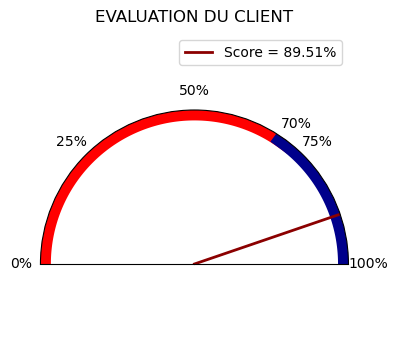

In [56]:
# Si vous voulez montrer la probabilité du premier échantillon par exemple:
sample_probability = probabilities[0]
draw_client(sample_probability)

In [57]:
print(probabilities)

[0.89512265]


DATA DRIFT

In [58]:
# Combinez X_train et y_train en un seul dataframe
train_df = pd.concat([X_train, y_train], axis=1)

# Combinez X_test et y_test en un seul dataframe
test_df = pd.concat([X_test, y_test], axis=1)

In [64]:
from evidently import ColumnMapping

from evidently.report import Report
from evidently.metrics.base_metric import generate_column_metrics
from evidently.metric_preset import DataDriftPreset, TargetDriftPreset, DataQualityPreset, RegressionPreset
from evidently.metrics import *

from evidently.test_suite import TestSuite
from evidently.tests.base_test import generate_column_tests
from evidently.test_preset import DataStabilityTestPreset, NoTargetPerformanceTestPreset
from evidently.tests import *

In [67]:
train_df.head()

,EXT_SOURCE_3,EXT_SOURCE_2,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_EDUCATION_TYPE_Higher education,OCCUPATION_TYPE_Core staff,FLAG_DOCUMENT_3,AMT_REQ_CREDIT_BUREAU_HOUR,CODE_GENDER,PAYMENT_RATE,TARGET
SK_ID_CURR,,,,,,,,,,,
346357,0.457900,0.551951,0,0,1,1,1,0.000000,1,0.038936,0.0
373639,0.509353,0.743099,1,1,0,0,0,0.000000,0,0.095137,0.0
378171,0.584990,0.597875,1,1,0,0,0,0.000000,0,0.050000,0.0
110649,0.452534,0.490217,1,1,0,0,1,0.000000,1,0.039941,0.0
344140,0.509353,0.733923,1,0,1,0,0,0.005809,1,0.050000,0.0


In [68]:
test_df.head()

,EXT_SOURCE_3,EXT_SOURCE_2,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_EDUCATION_TYPE_Higher education,OCCUPATION_TYPE_Core staff,FLAG_DOCUMENT_3,AMT_REQ_CREDIT_BUREAU_HOUR,CODE_GENDER,PAYMENT_RATE,TARGET
SK_ID_CURR,,,,,,,,,,,
414523,0.475850,0.575182,1,1,0,1,1,0.000000,1,0.029356,1.0
307855,0.509353,0.043098,0,1,0,0,0,0.000000,1,0.048830,0.0
172194,0.509353,0.707461,0,0,0,1,0,0.005809,1,0.051469,0.0
435350,0.754406,0.696917,0,1,0,0,0,0.000000,1,0.028941,0.0
289615,0.553165,0.729247,1,0,1,1,0,0.000000,1,0.107700,0.0


In [ ]:
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)


In [70]:
train_df = train_df.reset_index()
test_df = test_df.reset_index()

In [71]:
from evidently import ColumnMapping
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset

# Configuration des colonnes
column_mapping = ColumnMapping(
    target='TARGET', 
    numerical_features=list(train_df.columns)  # assurant que toutes vos colonnes sont numériques ici
)

# Création et exécution du rapport
drift_report = Report(metrics=[DataDriftPreset()])
drift_report.run(reference_data=train_df, current_data=test_df)
drift_report


In [72]:
from evidently.test_suite import TestSuite
from evidently.tests import *

# Configuration et exécution de la suite de tests
data_stability_tests = TestSuite(tests=[
    TestNumberOfColumnsWithMissingValues(),
    TestNumberOfRowsWithMissingValues(),
    TestNumberOfConstantColumns(),
    TestNumberOfDuplicatedRows(),
    TestNumberOfDuplicatedColumns(),
    TestColumnsType(),
    TestNumberOfDriftedColumns(),
])

data_stability_tests.run(reference_data=train_df, current_data=test_df)
data_stability_tests

c:\Users\arken\anaconda3\lib\site-packages\evidently\metrics\data_integrity\dataset_missing_values_metric.py:165: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [75]:
specific_column_tests = TestSuite(tests=[
    TestColumnDrift('TARGET'),
    # TestMeanInNSigmas('AveRooms'),  # Supprimé car 'AveRooms' n'est pas dans votre dataframe
    NoTargetPerformanceTestPreset(columns=['TARGET'])  # 'AveRooms' a été retiré
])

specific_column_tests.run(reference_data=train_df, current_data=test_df)
specific_column_tests


c:\Users\arken\anaconda3\lib\site-packages\evidently\metrics\data_integrity\dataset_missing_values_metric.py:165: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

